# Amazon K-Means Clustering With Subjectivity

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Load the NEW file with Linguistic Features
df = pd.read_csv("Reviews_With_Linguistic.csv")

features_list = ['SingleDayReviewFrequency', 'TextSentiment', 'ReviewLength', 'Score', 'Subjectivity']
X = df[features_list].fillna(0)

# Clustering 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Show the profile of the clusters
print(df.groupby('Cluster')[features_list].mean())

C:\Users\visha\AppData\Local\Temp\ipykernel_29460\477132147.py:11: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Reviews_With_Linguistic.csv")


         SingleDayReviewFrequency  TextSentiment  ReviewLength     Score  \
Cluster                                                                    
0                        3.988581       0.451217    251.180708  4.784355   
1                        3.390369       0.035752    415.112800  1.795435   
2                        4.779998       0.153440   1638.122535  4.201916   
3                        3.255005       0.184925    395.760229  4.764862   

         Subjectivity  
Cluster                
0            0.669484  
1            0.513767  
2            0.514196  
3            0.478281  


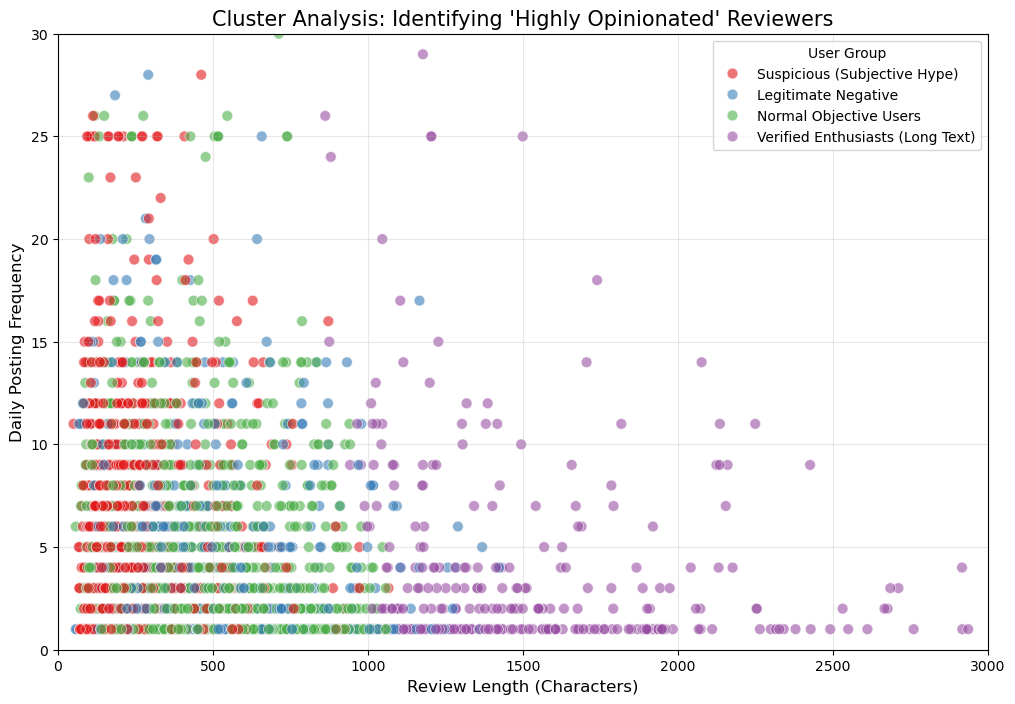

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cluster 0: Fakes (Short text, High Subjectivity)
# Cluster 1: Negative (Low Score)
# Cluster 2: Enthusiasts (Massive Length ~1600 chars)
# Cluster 3: Normal (Moderate Length, Objective)

cluster_names = {
    0: 'Suspicious (Subjective Hype)', 
    1: 'Legitimate Negative',
    2: 'Verified Enthusiasts (Long Text)', 
    3: 'Normal Objective Users'
}

df['Cluster_Label'] = df['Cluster'].map(cluster_names)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df.sample(5000, random_state=42), 
    x='ReviewLength', 
    y='SingleDayReviewFrequency', 
    hue='Cluster_Label', 
    palette='Set1',
    alpha=0.6,
    s=60 # Dot size
)

plt.title("Cluster Analysis: Identifying 'Highly Opinionated' Reviewers", fontsize=15)
plt.xlabel("Review Length (Characters)", fontsize=12)
plt.ylabel("Daily Posting Frequency", fontsize=12)
plt.legend(title="User Group")
plt.xlim(0, 3000) 
plt.ylim(0, 30)   
plt.grid(True, alpha=0.3)
plt.show()


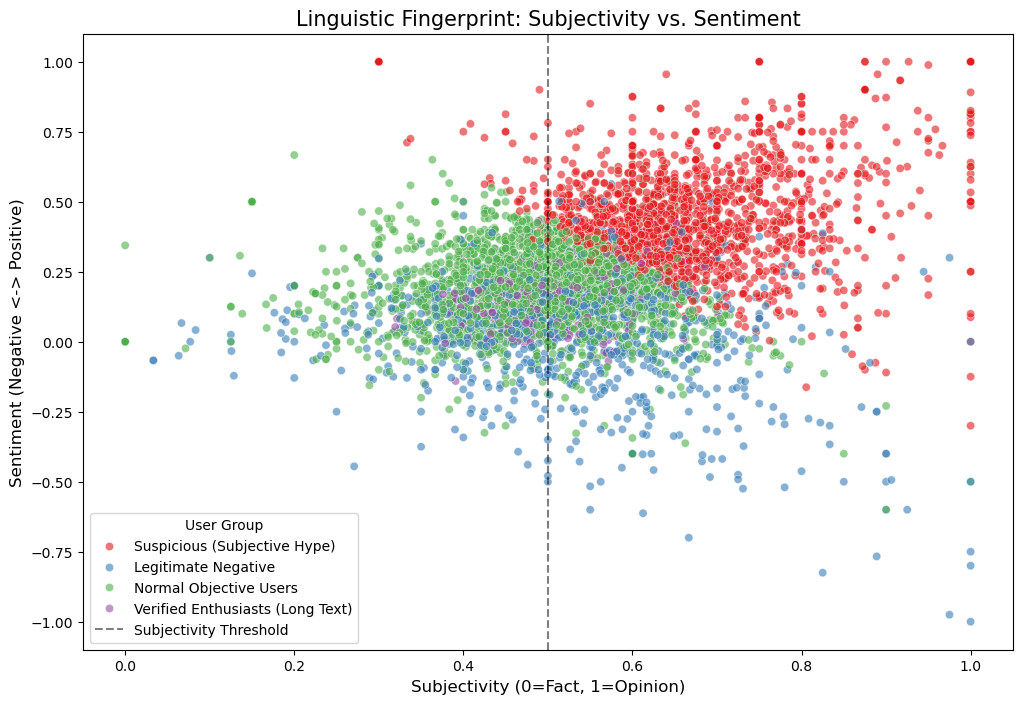

In [8]:
# Subjectivity vs. Sentiment
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x='Subjectivity', 
    y='TextSentiment', 
    hue='Cluster_Label', 
    palette='Set1',
    alpha=0.6
)

plt.title("Linguistic Fingerprint: Subjectivity vs. Sentiment", fontsize=15)
plt.xlabel("Subjectivity (0=Fact, 1=Opinion)", fontsize=12)
plt.ylabel("Sentiment (Negative <-> Positive)", fontsize=12)
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Subjectivity Threshold')
plt.legend(title="User Group")
plt.show()

# Amazon Decision Tree with Subjectivity

Model Accuracy: 94.82%
                    Feature  Importance
1             TextSentiment    0.681913
4              Subjectivity    0.270845
3                     Score    0.039257
2              ReviewLength    0.007985
0  SingleDayReviewFrequency    0.000000


C:\Users\visha\AppData\Local\Temp\ipykernel_29460\3282491126.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


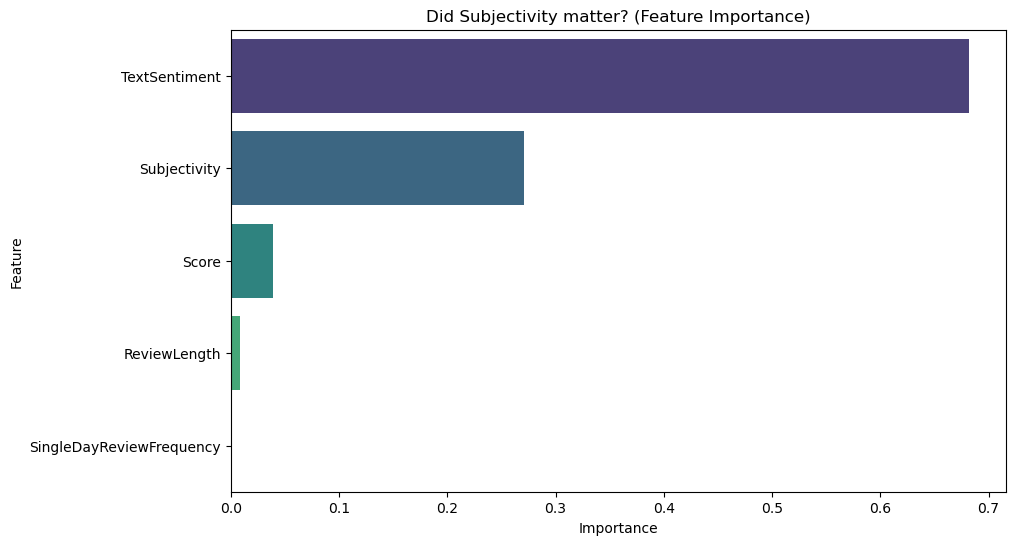

In [5]:
# Decision Tree 

# Cluster 0 is suspicious
df['Is_Fake'] = df['Cluster'].apply(lambda x: 1 if x == 0 else 0)
y = df['Is_Fake']

# Split & Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We use max_depth = 4 to keep the diagram readable
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

print(f"Model Accuracy: {dt_model.score(X_test, y_test)*100:.2f}%")

# Feature Importance
importances = pd.DataFrame({
    'Feature': features_list,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title("Did Subjectivity matter? (Feature Importance)")
plt.show()

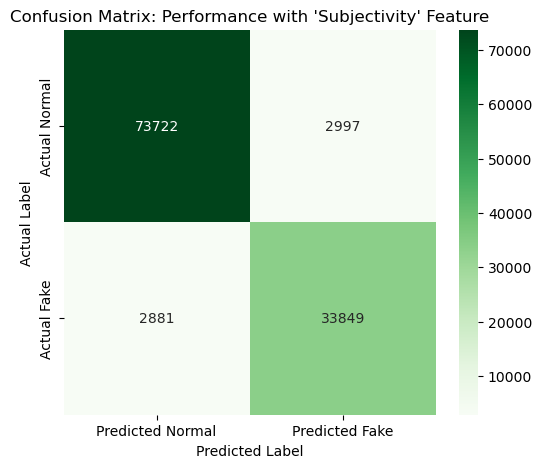

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96     76719
        Fake       0.92      0.92      0.92     36730

    accuracy                           0.95    113449
   macro avg       0.94      0.94      0.94    113449
weighted avg       0.95      0.95      0.95    113449



In [6]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predictions from the updated dt_model
y_pred = dt_model.predict(X_test)

# Calculate the Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted Normal', 'Predicted Fake'],
            yticklabels=['Actual Normal', 'Actual Fake'])

plt.title("Confusion Matrix: Performance with 'Subjectivity' Feature")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Normal', 'Fake']))

In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np

print("----RUNNING 5-FOLD CROSS VALIDATION----")


# Pass the whole X and y, and the function splits it automatically 5 times

scores = cross_val_score(dt_model, X, y, cv=5)

print("\nResults:")
print(f"Scores for each run: {scores}")
print(f"Average Accuracy:    {scores.mean()*100:.2f}%")
print(f"Standard Deviation:  {scores.std()*100:.3f}")


----RUNNING 5-FOLD CROSS VALIDATION----

Results:
Scores for each run: [0.94773863 0.94839972 0.94783559 0.94683955 0.94923665]
Average Accuracy:    94.80%
Standard Deviation:  0.079


C:\Users\visha\AppData\Local\Temp\ipykernel_29460\2158028096.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=folds, y=scores_pct, palette='viridis')


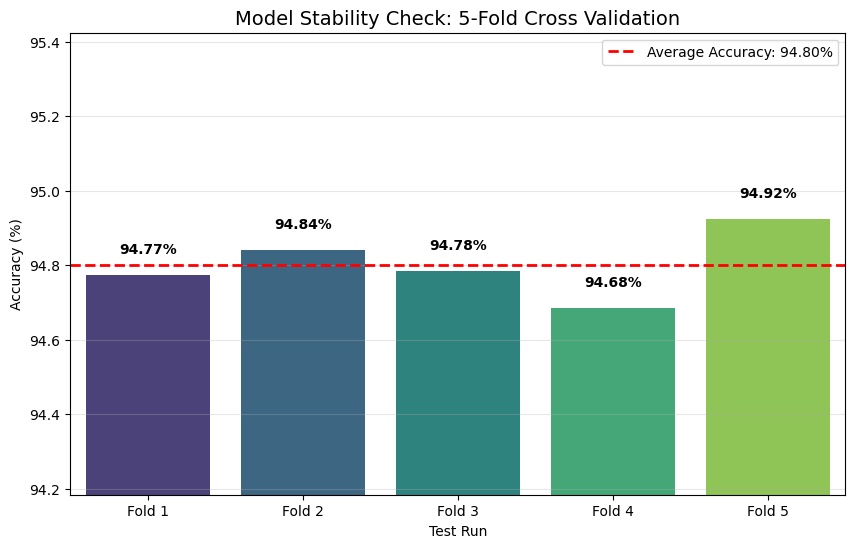

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

scores_pct = scores * 100
folds = [f'Fold {i+1}' for i in range(len(scores))]
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=folds, y=scores_pct, palette='viridis')

mean_score = scores_pct.mean()
plt.axhline(y=mean_score, color='red', linestyle='--', linewidth=2, label=f'Average Accuracy: {mean_score:.2f}%')

for i, v in enumerate(scores_pct):
    ax.text(i, v + 0.05, f"{v:.2f}%", ha='center', va='bottom', fontweight='bold')

plt.title("Model Stability Check: 5-Fold Cross Validation", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xlabel("Test Run")

plt.ylim(min(scores_pct) - 0.5, max(scores_pct) + 0.5) 
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()